# MRI Classification
*by Ali Lotfollahi*

## Libraries

In [4]:
from IPython.display import Image, display
import os
import numpy as np

## Parameters

In [5]:
DATA_LOCATION = 'dataset'

## Vectorized Functions

In [6]:
path_join = np.vectorize(os.path.join)

## Getting Data from File System

In [7]:
classes = os.listdir(DATA_LOCATION)
n_classes = len(classes)
classes

['notumor', 'pituitary', 'glioma', 'meningioma']

In [9]:
image_files = {}
for _class in classes:
    _class_files = os.listdir(os.path.join(DATA_LOCATION, _class))
    _class_file_paths = path_join(DATA_LOCATION, _class, _class_files)
    image_files.update({_class: _class_file_paths})

## Displaying Examples

'Class notumor:'

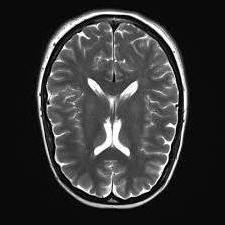

'Class pituitary:'

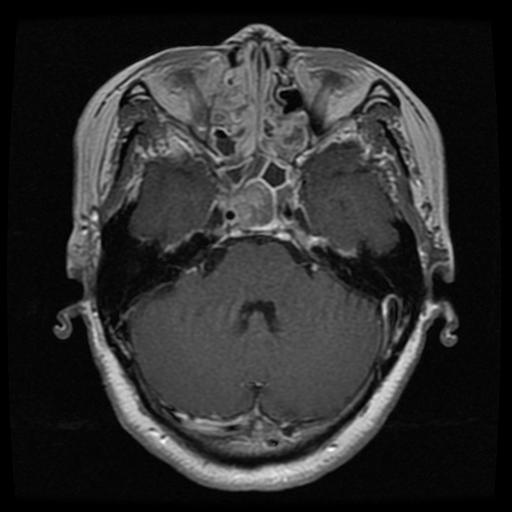

'Class glioma:'

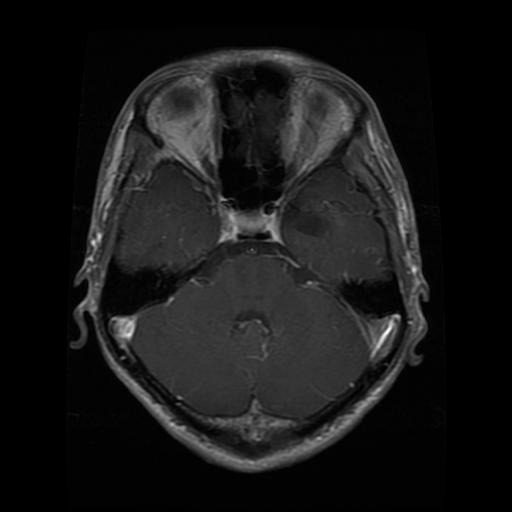

'Class meningioma:'

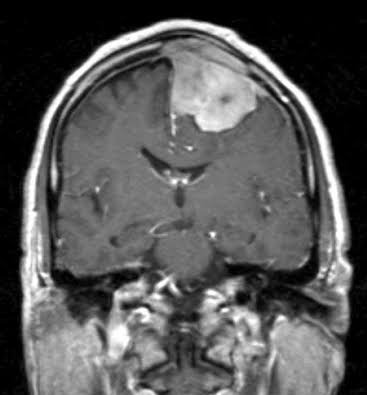

In [36]:
for _class in classes:
    _index = np.random.randint(0, len(image_files[_class]))
    display(f"Class {_class}:")
    display(Image(image_files[_class][_index], width=200, height=200))

## Reading Files